# Analysis of #IoT Tweets

The following is an exploratory analysis of over 8 million tweets containing the hashtag **#IoT**. The tweets were recorded in a period from October 2016 to May 2017 using a [Twitter stream listener](https://github.com/neocortex/twitter-stream) and saved in DynamoDB. The data was retrieved from DynamoDB and saved in a local CSV file.

The notebook showcases basic analyses in Python applied to text data.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Imports

Importing a number of libraries used throughout the notebook.

In [2]:
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pylab as pl
from wordcloud import WordCloud

import preprocess

%matplotlib inline
pl.style.use('ggplot')

### Load data

Loading the data from the local CSV file.

In [3]:
df = pd.read_csv('tweets.csv')

In [4]:
len(df)

8651221

### Preprocess data

Some simple data preparation on the raw data retrieved from DynamoDB.

In [5]:
df = preprocess.main(df)

In [6]:
df.head()

,lang,n_retweets,text,timestamp,tweet_id,urls,user_name,hashtags
0,en,0,rt @apracor: rt @rtinfluencer: the #iot cybers...,1492348165271,853596189446598656,[],hackerslist,"[iot, iotsecurity]"
1,fr,0,@oceasoft membre du réseau #iot #manufacturing...,1492628651194,854772632675393537,[],montpellierft,"[iot, manufacturing, hotelfrenchtech, montpell..."
2,und,0,#riodosul #ivosilveira #iot #ssp #comunidade h...,1482808087702,813582203938541568,[],rsl5minivs,"[riodosul, ivosilveira, iot, ssp, comunidade]"
3,en,0,virtualvehicle vw touran has just left work! ...,1487052047955,831382663403446273,[],sam weeks,"[iot, bluemix]"
4,en,0,rt @jimmarous: artificial intelligence statist...,1489281992917,840735730477481984,[],john snow,"[fintech, healthtech, insurtech, ai, artificia..."


In [7]:
df.to_pickle('tweets_preprocessed.pkl')

## Data Exploration

### Date range

Display the perdiod in which the tweets were recorded.

In [8]:
# df = pd.read_pickle('tweets_preprocessed.pkl')

In [9]:
from_date = datetime.fromtimestamp(int(df.timestamp.min()) / 1000)
to_date = datetime.fromtimestamp(int(df.timestamp.max()) / 1000)
print('Tweets from {} to {}.'.format(from_date.date(), to_date.date()))
print('Time period: {} days.'.format((to_date - from_date).days))

Tweets from 2016-10-14 to 2017-05-02.
Time period: 200 days.


### Common hashtags

Analysing the most common hashtags that appear together with the hashtag **#IoT##.

In [10]:
hashtags = ['#'+x for l in df.hashtags.values for x in l]
c = Counter(hashtags)

In [11]:
ht, counts = list(zip(*c.most_common()[1:11]))

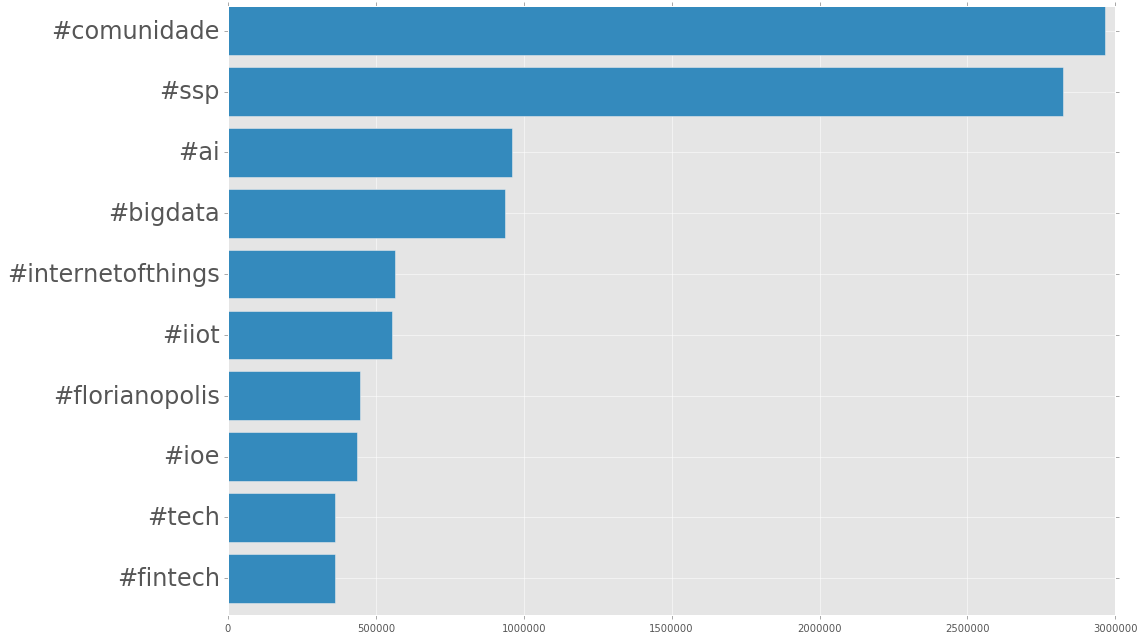

In [12]:
fig, ax = pl.subplots(1, figsize=(16,9))

y = np.arange(len(ht))
ax.barh(y, counts)
ax.set_yticks(y + 0.4)
ax.set_yticklabels(ht, fontsize=24)
ax.invert_yaxis()

pl.tight_layout()
pl.savefig('top10_hashtags.png')

### Drop brasilian safety tweets

The secretary for public safety (SSP) has lauched a program for the usage of cameras for security purposes in a department of brasil called [bem-te-vi](http://www.ssp.sc.gov.br/index.php?option=com_content&view=article&id=527:lanca-programa-bem-te-vi-que-visa-melhorar-o-sistema-de-videomonitoramento-do-estado&catid=51:noticias-da-secretaria&Itemid=180). Apparently images from these cameras get sent to twitter on a regular basis and [all of them are tagged with '#IoT'](https://twitter.com/search?f=tweets&q=%23ssp&src=type). That's why those tweets are first removed here.

In [13]:
df['drop'] = df.hashtags.apply(lambda x: ('ssp' in x) or ('comunidade' in x))
df = df[(df['drop'] == False)]
df.drop('drop', inplace=True, axis=1)

In [14]:
len(df)

5684666

### Again: Top hashtags

Most common hashtags that appear along with #IoT after removing SSP tweets.

In [15]:
hashtags = ['#'+x for l in df.hashtags.values for x in l]
c = Counter(hashtags)

In [16]:
top = 20
ht, counts = list(zip(*c.most_common()[1:top+1]))

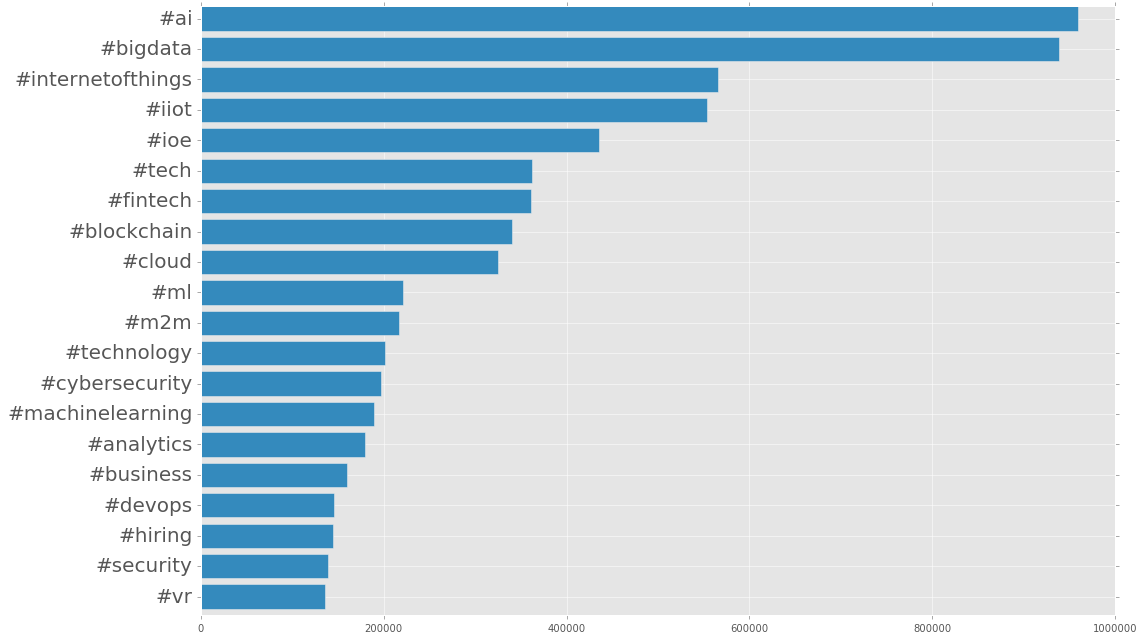

In [17]:
fig, ax = pl.subplots(1, figsize=(16, 9))

y = np.arange(len(ht))
ax.barh(y, counts)
ax.set_yticks(y + 0.4)
ax.set_yticklabels(ht, fontsize=20)
ax.invert_yaxis()

pl.tight_layout()
pl.savefig('top10_hashtags_cleaned.png')

### Hashtags wordcloud

Create a wordcloud of all hashtags.

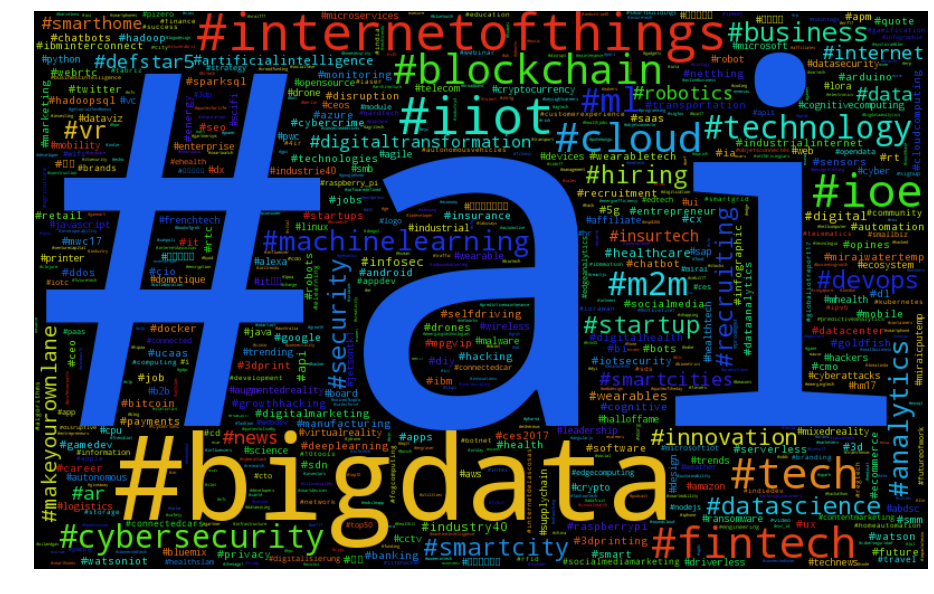

In [18]:
wc = WordCloud(relative_scaling=.5, width=800, height=500, background_color='black',
               max_words=1000).generate_from_frequencies(c.most_common()[1:])
fig, ax = pl.subplots(1, figsize=(16,10))
ax.imshow(wc, interpolation="bilinear")
ax.axis('off');

### Top users

Analyse the most active users.

In [19]:
value_counts = df.user_name.value_counts()[:10]

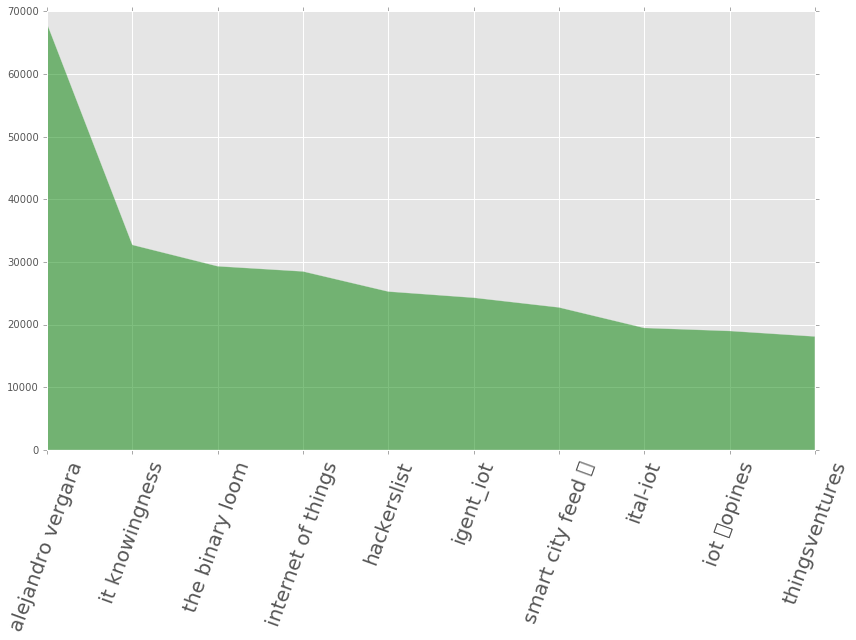

In [20]:
fig, ax = pl.subplots(1, figsize=(12, 9))
x = np.arange(len(value_counts.index))
ax.stackplot(x, value_counts.values, colors='g', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(value_counts.index, fontsize=20, rotation=70)
ax.grid(color='w', linestyle='-', linewidth=1)

pl.tight_layout()
pl.savefig('top10_users.png')

### Most common languages

Take a look at the most common languages.

In [21]:
lang_counts = df.lang.value_counts(normalize=True)

In [22]:
en = lang_counts.en
und = lang_counts.und
other = lang_counts.drop(['en', 'und']).sum()

labels = ['english', 'undefined', 'other']
values = [en, und, other]

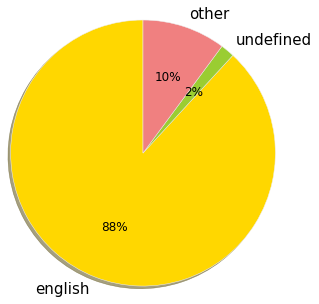

In [23]:
fig, ax = pl.subplots(1, figsize=(4, 4))

patches, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.0f%%',
       shadow=True, startangle=90, colors=[
        'gold', 'yellowgreen', 'lightcoral', 'lightskyblue'])
[text.set_fontsize(15) for text in texts]
for t in autotexts:
    t.set_size('large')

ax.axis('equal')

pl.tight_layout()
pl.savefig('top_languages.png',  bbox_inches='tight')

### Drop non-english tweets

Because subsequent analyses are based on the tweets' texts, all non-english tweets are dropped.

In [24]:
df = df[df.lang == 'en']

In [25]:
len(df)

5009721

### Drop retweets

We also drop all retweets.

In [26]:
df = df[~df.text.apply(lambda x: x.startswith('rt'))]
len(df)

1651356

In [27]:
df.to_pickle('tweets_english_no_retweets.pkl')

### Top hashtags without retweets

Let's take a second look at the top hashtags after retweets are removed.

In [28]:
# df = pd.read_pickle('tweets_english_no_retweets.pkl')

In [29]:
hashtags = ['#'+x for l in df.hashtags.values for x in l]
c = Counter(hashtags)

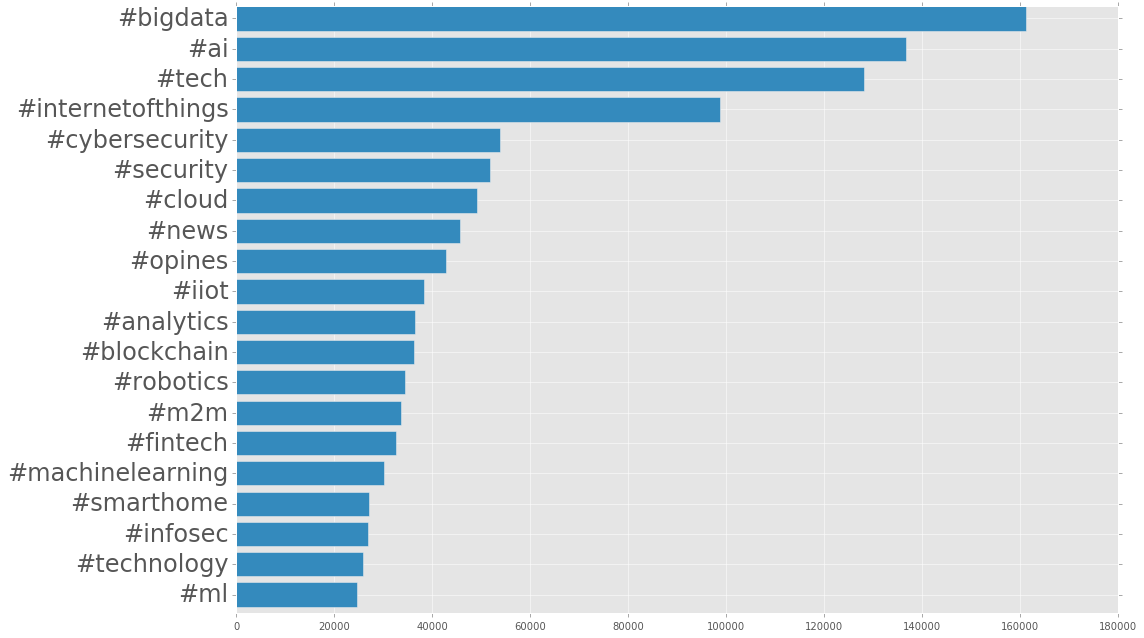

In [30]:
top = 20
most_common = c.most_common()[1:]
x, y = zip(*most_common[:top])

fig, ax = pl.subplots(1, figsize=(16,9))
ax.barh(range(len(x)), y)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(x)) + 0.4)
ax.set_yticklabels(x, fontsize=24)

pl.tight_layout()
pl.savefig('top10_hashtags_cleaned_no_retweets.png')

And the same for the wordcloud of hashtags.

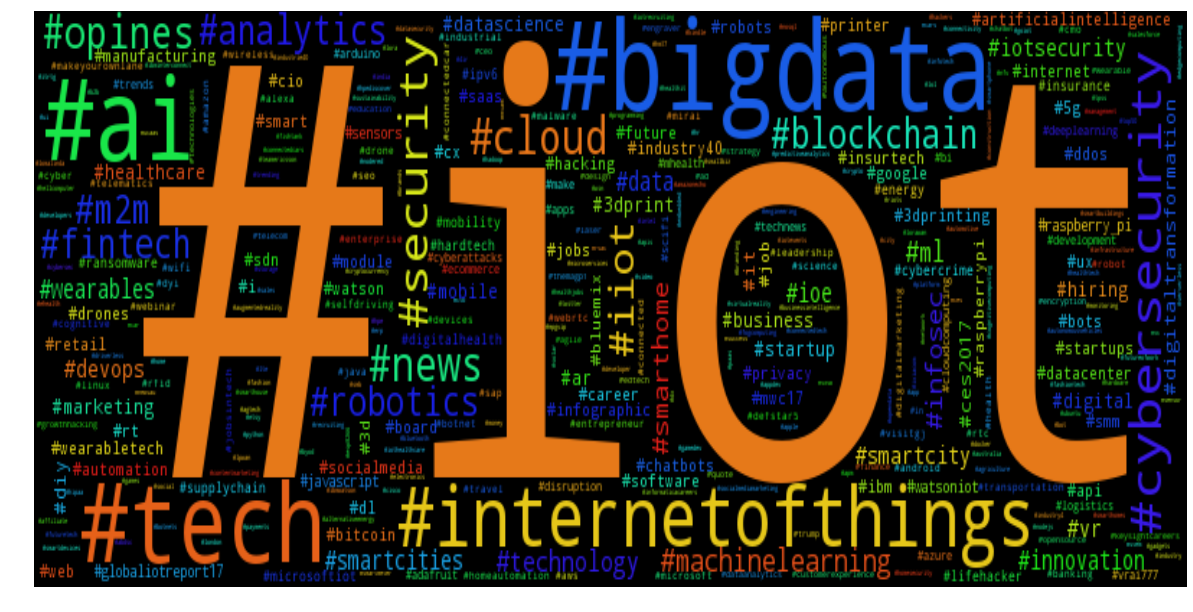

In [31]:
wc = WordCloud(relative_scaling=.5, width=800, height=300, background_color='black',
               max_words=1000).generate_from_frequencies(c.most_common()[0:])
fig = pl.figure(figsize=(16,8), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(wc, aspect='normal')
fig.savefig('hashtag_wordcloud.png', dpi=300)

## Text processing

In [32]:
import re
import string

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import TweetTokenizer

### Load stopwords

Load a list of stopwords.

In [33]:
with open('stopwords.txt', 'r') as f:
    stopwords = [x.strip() for x in f.readlines()]

### Clean texts

Clean the tweets' texts by:

- Removing tickers
- Removing hyperlinks
- Removing puctuation
- Removing stopwords
- Removing single characters

In [34]:
tweets = df.text.tolist()

In [35]:
def clean_tweet(tweet):
    # Remove tickers
    tweet = re.sub(r'\$\w*','', tweet)
    # Remove URLs
    tweet = re.sub(r'https?:\/\/.*\/\w*','', tweet)
    # Remove puncutation
    tweet = re.sub(r'[' + string.punctuation + ']+', ' ', tweet)
    # Tokenize text
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    # Remove stopwords and single characters
    tokens = [i.lower() for i in tokens if i not in stopwords and len(i) > 1]
    return tokens

In [36]:
cleaned_tweets = []
for tweet in tweets:
    cleaned_tweets.append(clean_tweet(tweet))

In [37]:
len(cleaned_tweets), len(df)

(1651356, 1651356)

In [38]:
df['cleaned_text'] = cleaned_tweets

In [39]:
df.to_pickle('tweets_with_cleaned_text.pkl')

### Most frequent words

Let's take a look at the most frequent words appearing in **#IoT** tweets.

In [40]:
df = pd.read_pickle('tweets_with_cleaned_text.pkl')

In [41]:
words = [x for l in df.cleaned_text.values for x in l]

In [42]:
len(words)

14755141

In [43]:
c = Counter(words)

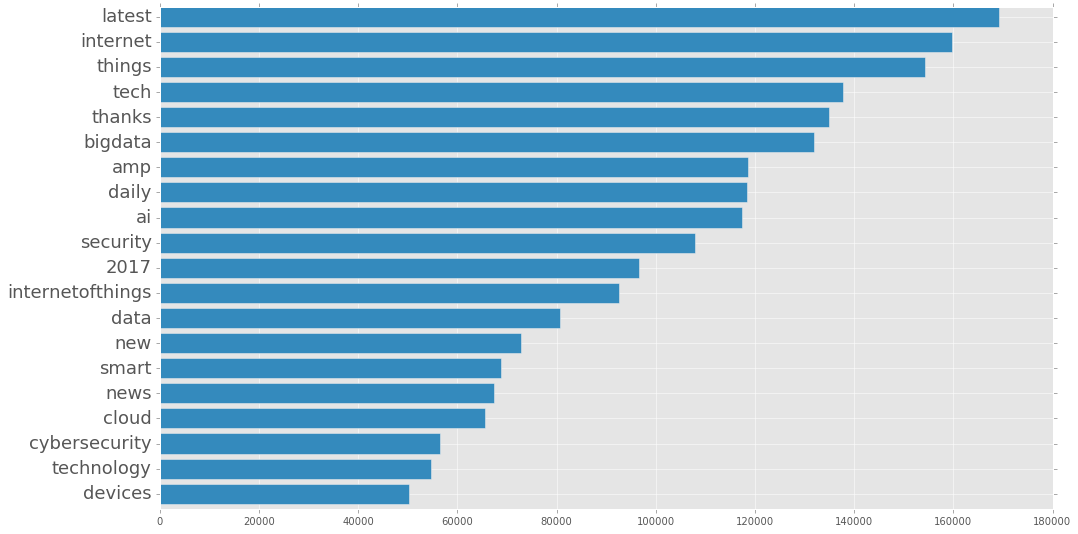

In [44]:
top = 20
most_common = c.most_common()[1:]
x, y = zip(*most_common[:top])

fig, ax = pl.subplots(1, figsize=(16,9))
ax.barh(range(len(x)), y)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(x)) + 0.4)
ax.set_yticklabels(x, fontsize=18);

And produce a wordcloud from it.

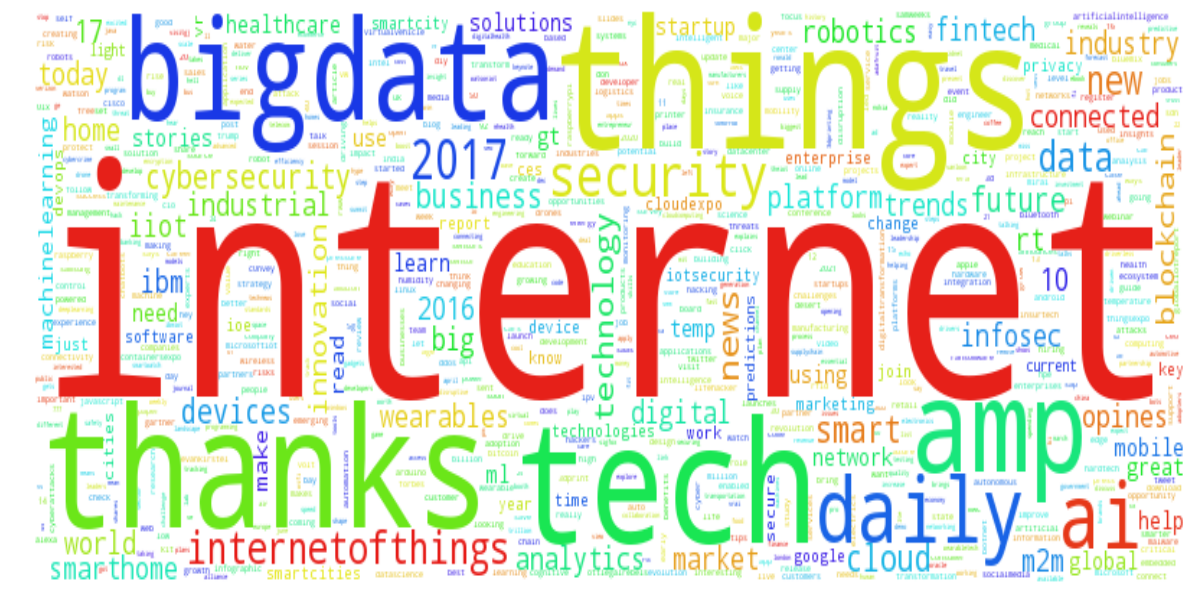

In [69]:
wc = WordCloud(relative_scaling=.5, width=800, height=300, background_color='white',
               max_words=1000).generate_from_frequencies(c.most_common()[2:])
fig = pl.figure(figsize=(16,8), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(wc, aspect='normal')
fig.savefig('text_wordcloud.png', dpi=300)

### Bigrams

Instead of just looking at word frequencies we can also take a look a word bigrams.

In [46]:
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words, 2)
finder.apply_freq_filter(5)

In [47]:
for bigram in finder.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)

('internet', 'things')
('daily', 'thanks')
('raspberry', 'pi')
('iot', 'iot')
('ces', '2017')
('press', 'release')
('opines', 'iot')
('current', 'state')
('cybersecurity', 'infosec')
('state', 'temp')
('big', 'data')
('artificial', 'intelligence')
('electrics', 'bay')
('iot', 'robotics')
('mwc', '17')
('3d', 'printer')
('virtualvehicle', 'vw')
('smart', 'cities')
('samweeks', '92')
('bluemix', 'samweeks')


## Clustering

Simple KMeans clustering using TF-IDF features and *n=5* clusters.

In [48]:
cleaned_texts = df.cleaned_text.apply(lambda x: ' '.join(x))

In [49]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1, 2))  
transformed = vectorizer.fit_transform(cleaned_texts.values)

In [50]:
transformed.shape

(1651356, 2915310)

In [51]:
features = vectorizer.get_feature_names()

In [52]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1)
kmeans.fit(transformed)
clusters = kmeans.labels_.tolist()
df['cluster_id'] = clusters

df.cluster_id.value_counts()

0    1154593
2     204405
4     155464
1     132017
3       4877
Name: cluster_id, dtype: int64

In [53]:
# sort cluster centers by proximity to centroid
centroids_order = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order[i, :10]:
        print('\t{}'.format(features[idx]))



Top terms in cluster 0:

	iot
	security
	amp
	2017
	smart
	new
	tech
	internetofthings
	data
	devices


Top terms in cluster 1:

	things
	internet
	internet things
	things iot
	iot
	internetofthings
	internetofthings iot
	security
	industrial internet
	iot internetofthings


Top terms in cluster 2:

	bigdata
	ai
	iot
	robotics
	iot robotics
	iot bigdata
	bigdata iot
	iot ai
	ai iot
	ml


Top terms in cluster 3:

	web news
	web
	news iot
	news
	iot
	news ioe
	ioe
	iot news
	fandomtrash 714
	fandomtrash


Top terms in cluster 4:

	latest
	daily
	thanks
	daily thanks
	iot
	tech
	daily iot
	news
	iot tech
	tech iot


## Topic modelling

Topic modelling using LDA (gensim implementation).

In [54]:
from gensim import corpora, models
from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()

def lemmatize(text):
    return ' '.join(lemma.lemmatize(word) for word in text.split())

texts = [text for text in cleaned_texts.values if len(text) > 1]
lemmatized_texts = [lemmatize(text).split() for text in texts]

Using Theano backend.


In [55]:
dictionary = corpora.Dictionary(lemmatized_texts)
terms_matrix = [dictionary.doc2bow(doc) for doc in lemmatized_texts]

In [ ]:
ldamodel = models.ldamodel.LdaModel(
    terms_matrix, num_topics=5, id2word=dictionary, passes=5)

for topic in ldamodel.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Top terms in topic {}: ".format(topic[0]))
    words = [w for (w, val) in topic[1]]
    print(words)

## Sentiment analysis

Sentiment analysis of tweets using TextBlob.

In [57]:
from textblob import TextBlob

In [58]:
def get_tweet_sentiment(tweet):
    return TextBlob(tweet).sentiment.polarity

In [59]:
df['sentiment'] = df.cleaned_text.apply(lambda x: get_tweet_sentiment(' '.join(x)))

In [60]:
THR = 0.2

In [61]:
neg = df[df.sentiment < -THR]
pos = df[df.sentiment > THR]

In [62]:
neg_text = ' '.join(neg.cleaned_text.apply(lambda x: ' '.join(x))).replace('iot', '')
pos_text = ' '.join(pos.cleaned_text.apply(lambda x: ' '.join(x))).replace('iot', '')

In [63]:
Counter(neg_text.split(' ')).most_common()[1:10]

[('artificial', 6251),
 ('intelligence', 6033),
 ('security', 5680),
 ('internet', 5084),
 ('things', 4592),
 ('ai', 4066),
 ('bigdata', 3297),
 ('tech', 3155),
 ('mean', 2867)]

In [64]:
Counter(pos_text.split(' ')).most_common()[1:10]

[('latest', 158322),
 ('thanks', 117687),
 ('daily', 89872),
 ('tech', 50123),
 ('smart', 49609),
 ('news', 30052),
 ('amp', 24921),
 ('bigdata', 24673),
 ('internet', 23461)]

In [67]:
for t in df[df.sentiment == df.sentiment.min()].text[:5]:
    print(t + '\n')

binaryloom: rt nabilbouzerna: 5 worst #iot #hacks &amp; #vulnerabilities in the history https://t.co/unrvlcnovj... https://t.co/mszjeoippb

the worst internet of things stocks of 2016 https://t.co/llryy1z2bj #iot

despite increased interest, internet of things is still struggling with one of the worst problems of the hi-tech in… https://t.co/hwq009qcnt

dns evil lurking around every corner https://t.co/adototrd27 #cybersecurity #infosec #iot #bigdata #security #tech

🐳 @titoyooo 🗯 "ces has looked insane, but also like a lot of junk. you know i'm investing in #iot... https://t.co/scqwrly4hm by #ranidu



In [68]:
for t in df[df.sentiment == df.sentiment.max()].text[:5]:
    print(t + '\n')

hey @best_kickstart! any chance of a rt for our #networksecurity toolkit, fingbox?! https://t.co/j6w30eztnj #iot #smarthome #infosec

try the best this! https://t.co/opmbgc8xpw

the best of #bluemix, #hybrid, #iot &amp; more, only at #ibminterconnect. what are you waiting for? https://t.co/qg4vaquz8b

awesome roundup of internet of things forecasts and market estimates, 2016 https://t.co/hfqmxmlmrq via… https://t.co/kwnvzpsjm4

here's our pick for best industrial #iot articles for the day.  https://t.co/ycmlg8dgwp stories via @smartwohnen2016 @rebazeio @dataentrybpo

